In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading data

In [8]:
FILE_PATH = 'clickbait_data.csv'
data = pd.read_csv(FILE_PATH)
data

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


# Train-test split

In [10]:
text = data['headline'].values
labels = data['clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels)
print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

(24000,) (8000,) (24000,) (8000,)


# Tokenize text

In [11]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Define and train model

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
# model.add(LSTM(32, return_sequences=True))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          16640     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 176,705
Trainable params: 176,705
Non-trai

In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
11/47 [======>.......................] - ETA: 34:00 - loss: 0.6911 - accuracy: 0.6064

In [11]:
model.load_weights('weights.h5')
model.save('model')

In [24]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

In [1]:
# !zip -r 'clickbait_model.zip' 'model'

# Plot training metrics

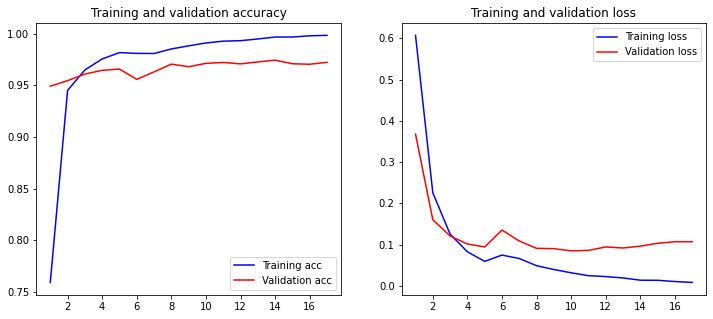

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Plot confusion matrix and metrics

250/250 [==============================] - 3s 11ms/step


<Figure size 432x288 with 0 Axes>

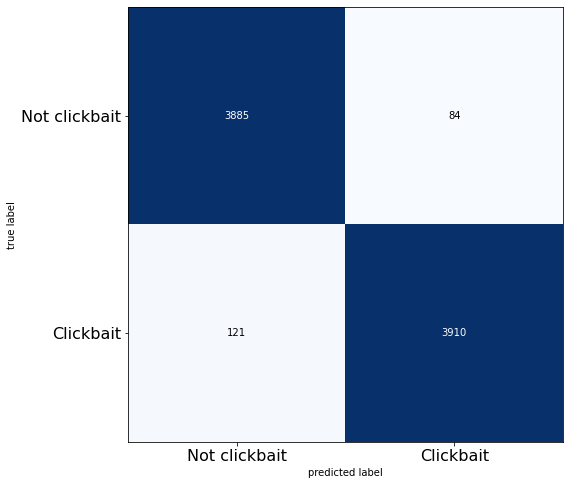

In [19]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [20]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.98


# Run predictions on arbitrary user input

In [21]:
test = ['My biggest laugh reveal ever!', 'Learning game development with Unity', 'A tour of Japan\'s Kansai region', '12 things NOT to do in Europe']
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 1s 641ms/step
My biggest laugh reveal ever! - Clickbait
Learning game development with Unity - Not Clickbait
A tour of Japan's Kansai region - Not Clickbait
12 things NOT to do in Europe - Not Clickbait


In [22]:
import tensorflow as tf

# Load the saved model
model1 = tf.keras.models.load_model('model')

# Load the saved weights
model1.load_weights('weights.h5')


In [25]:
test = ['My biggest laugh reveal ever!', 'Learning game development with Unity', 'A tour of Japan\'s Kansai region', '12 things NOT to do in Europe']
token_text = pad_sequences(tokenizer1.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model1.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 1s 626ms/step
My biggest laugh reveal ever! - Clickbait
Learning game development with Unity - Not Clickbait
A tour of Japan's Kansai region - Not Clickbait
12 things NOT to do in Europe - Not Clickbait


In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=15)
clf = knn.fit(X_train, y_train)
y_pred = clf.predict(x_test)
acc_knb_model=roc_auc_score(y_test, y_pred)*100
acc_knb_model

66.04009830791662

In [17]:
lr = LogisticRegression(C = 0.2)
clf1 = lr.fit(X_train, y_train)
y_pred1 = clf1.predict(x_test)
acc_log_reg=roc_auc_score(y_test, y_pred1)*100
acc_log_reg

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


61.47323474703265

In [18]:
clf2 = GaussianNB().fit(X_train, y_train)
y_pred2 = clf2.predict(x_test)
acc_nb=roc_auc_score(y_test, y_pred2)*100
acc_nb

52.68672715602418

In [19]:
clf3 = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred3 = clf3.predict(x_test)
acc_dt=roc_auc_score(y_test, y_pred3)*100
acc_dt

76.60435489367937

In [20]:
clf4 = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)
y_pred4 = clf4.predict(x_test)
acc_rmf_model=roc_auc_score(y_test, y_pred4)*100
acc_rmf_model

75.0673935324713

In [21]:
sgd_model=SGDClassifier()
sgd_model.fit(X_train,y_train)
sgd_pred=sgd_model.predict(x_test)
acc_sgd=round(sgd_model.score(X_train,y_train)*100,10)
acc_sgd

63.7916666667

In [22]:
xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)
xgb_pred=xgb_model.predict(x_test)
acc_xgb=round(xgb_model.score(X_train,y_train)*100,10)
acc_xgb

95.0083333333

In [23]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_pred=lgbm.predict(x_test)
acc_lgbm=round(lgbm.score(X_train,y_train)*100,10)
acc_lgbm

90.8583333333

In [24]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
regr_pred=regr.predict(x_test)
acc_regr=round(regr.score(X_train,y_train)*100,10)
acc_regr

12.1568656949

In [25]:
clf5 = SVC(gamma='auto').fit(X_train, y_train)
y_pred5 = clf5.predict(x_test)
acc_svm_model=roc_auc_score(y_test, y_pred5)*100
acc_svm_model

51.13029349598964

In [26]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest','Stochastic Gradient Decent','Linear Regression','Naive Bayes','XGBoost','LightGBM','Decision Tree'],
    'Score': [acc_svm_model, acc_knb_model, acc_log_reg, 
              acc_rmf_model,acc_sgd,acc_regr,acc_nb,acc_xgb,acc_lgbm,acc_dt]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
95.008333,XGBoost
90.858333,LightGBM
76.604355,Decision Tree
75.067394,Random Forest
66.040098,KNN
63.791667,Stochastic Gradient Decent
61.473235,Logistic Regression
52.686727,Naive Bayes
51.130293,Support Vector Machines


In [ ]:

# Score	    Model
# 95.008333	XGBoost
# 90.858333	LightGBM
# 76.604355	Decision Tree
# 75.067394	Random Forest
# 66.040098	KNN
# 63.791667	Stochastic Gradient Decent
# 61.473235	Logistic Regression
# 52.686727	Naive Bayes
# 51.130293	Support Vector Machines
# 12.156866	Linear Regression
